In [ ]:
!pip install TA-Lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 20.8 MB/s eta 0:00:00


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LogisticRegression
from scipy.stats import spearmanr
from numpy.linalg import inv, eig, svd
import yfinance as yf


In [ ]:

tickers = [
    # Top 10 Energy Stocks
    "XOM","CVX","SHEL","TTE","COP","ENB","BP","ET","KMI","LNG",
    "MPC","DINO","EQT","EXE","CNX","AR","VLO","RRC","TPL","PR","CVE","EOG","OKE","PSX","SLB","WMB",

    # Top 10 Tech Stocks
    "NVDA","MSFT","AAPL","ASML","AMD","CSCO","CRM","IBM","UBER","TXN",
    "TSM","AVGO","QCOM","AMAT","ADI","KLAC","MU","CRWD","PANW","INFY","ZS","OKTA","LDOS","NET",
    "FSLR","NXT","ENPH","META","AMZN","NFLX","TSLA","COST",

    # Top 10 ETFs
    "VOO","SPY","IVV","VTI","QQQ","VEA","IEMG","AGG","IWF","ARKK",
    "XLE","VDE","IXC","XOP","VNQ","IYR","RWR","REET","HAUS","XLRE","FPE",
    "XLK","VGT","IYW","SMH","CIBR","ICLN","GDX","FDN","FXL","PSCT","XSW",
    "SPYV","VOE","VBR","PXF","VYMI","XMVM","EUFN","EEM","VNQI","EWZ","FXI","IWN",
    "SOXX","SOXQ","FTXL","XSD","PSI",

    # Top 10 Quantum
    "ARQQ","QUBT","QBTS","INTC","LAES","QMCO","HON","GOOGL","RGTI","IONQ",

    # Others
    "BRK-B","JPM","UNH","JNJ","PG","WMT","ABBV","HD","PM","VZ","KO","MO","LMT","PGR","T",
    "HO.PA","SSE.L","VWS.CO","IBE.MC","600900.SS","EQTL3.SA","EDP.LS","SUZLON.NS",
    "IFNNY","NXPI","ACLS","TXT","RKLB","AVAV","KTOS","PL","SPIR","BAB.L","GOOG",
]



start = "2024-01-01"
end   = None

stocks = yf.download(
    tickers=tickers,
    start=start,
    end=end,
    interval="60m",
    auto_adjust=True,
    progress=False,
    group_by="column"
)




In [ ]:

def get_sector_industry_yf(symbol: str):
    """
    Returns (sector, industry) for equities when Yahoo has it.
    For ETFs/funds, these fields are often missing.
    """
    try:
        info = yf.Ticker(symbol).get_info()
        return info.get("sector"), info.get("industry")
    except Exception:
        return None, None

rows = []
for i, sym in enumerate(tickers, 1):
    sector, industry = get_sector_industry_yf(sym)
    rows.append({"ticker": sym, "sector": sector, "industry": industry})
    time.sleep(0.2)

sector_df = pd.DataFrame(rows)

unique_syms = pd.Index(tickers, name="ticker").unique()
sector_df = sector_df[sector_df["ticker"].isin(unique_syms)]

print(sector_df.head())

def restructure_and_merge_data(stocks_df, sector_df):
    stocks_df.index.name = 'date'

    long_df = stocks_df.stack(level=1)

    long_df = long_df.rename(columns=str.lower)

    long_df = long_df.swaplevel().sort_index()

    long_df.index.names = ['ticker', 'date']

    merged_df = long_df.join(sector_df.set_index('ticker'))

    merged_df = merged_df.dropna(subset=['sector', 'industry'])

    print("Data successfully restructured and merged.")
    return merged_df

prices = restructure_and_merge_data(stocks, sector_df)
print(prices.head())

  ticker  sector              industry
0    XOM  Energy  Oil & Gas Integrated
1    CVX  Energy  Oil & Gas Integrated
2   SHEL  Energy  Oil & Gas Integrated
3    TTE  Energy  Oil & Gas Integrated
4    COP  Energy         Oil & Gas E&P


/tmp/ipython-input-3416075499.py:44: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long_df = stocks_df.stack(level=1)


Data successfully restructured and merged.
                                         close       high        low  \
ticker    date                                                         
600900.SS 2024-01-02 01:30:00+00:00  23.660000  23.660000  23.330000   
          2024-01-02 02:30:00+00:00  23.620001  23.660000  23.590000   
          2024-01-02 03:30:00+00:00  23.610001  23.610001  23.610001   
          2024-01-02 04:30:00+00:00  23.670000  23.670000  23.610001   
          2024-01-02 05:30:00+00:00  23.730000  23.770000  23.670000   

                                          open      volume     sector  \
ticker    date                                                          
600900.SS 2024-01-02 01:30:00+00:00  23.350000  25480870.0  Utilities   
          2024-01-02 02:30:00+00:00  23.650000  13934467.0  Utilities   
          2024-01-02 03:30:00+00:00  23.610001      5300.0  Utilities   
          2024-01-02 04:30:00+00:00  23.629999   6628811.0  Utilities   
          2024

In [ ]:
import talib
import numpy as np
import pandas as pd

def calculate_dollar_volume(df):
    df['dollar_vol'] = df[['close', 'volume']].prod(axis=1)

    df['dollar_vol_1m'] = (df.groupby('ticker')
                             .dollar_vol
                             .rolling(window=21)
                             .mean()
                             .reset_index(level=0, drop=True))

    df['dollar_vol_rank'] = (df.groupby('date')
                               .dollar_vol_1m
                               .rank(ascending=False))
    return df

def calculate_technical_indicators(df):
    def compute_rsi(group):
        rsi_values = talib.RSI(group['close'].values)
        return pd.Series(rsi_values, index=group.index)

    def compute_bollinger(group):
        high, mid, low = talib.BBANDS(group['close'].values, timeperiod=20)
        bb_high = pd.Series(high, index=group.index).sub(group['close']).div(pd.Series(high, index=group.index)).apply(np.log1p)
        bb_low = pd.Series(low, index=group.index)
        bb_low = group['close'].sub(bb_low).div(group['close']).apply(np.log1p)

        return pd.DataFrame({'bb_high': bb_high, 'bb_low': bb_low}, index=group.index)


    def compute_atr(group):
        atr = talib.ATR(group['high'].values, group['low'].values, group['close'].values, timeperiod=14)
        atr_series = pd.Series(atr, index=group.index)
        return atr_series.sub(atr_series.mean()).div(atr_series.std())

    def compute_macd(group):
        macd = talib.MACD(group['close'].values)[0]
        macd_series = pd.Series(macd, index=group.index)
        return macd_series.sub(macd_series.mean()).div(macd_series.std())


    df['rsi'] = df.groupby(level='ticker', group_keys=False).apply(compute_rsi)

    bb_df = df.groupby(level='ticker', group_keys=False).apply(compute_bollinger)
    df = pd.concat([df, bb_df,], axis=1)

    df['atr'] = df.groupby(level='ticker', group_keys=False).apply(compute_atr)
    df['macd'] = df.groupby(level='ticker', group_keys=False).apply(compute_macd)


    print("Technical indicators calculated.")
    return df



prices = calculate_dollar_volume(prices)
prices = calculate_technical_indicators(prices)
print(prices.info())

def calculate_returns(df):
    """
    Calculates various lagged and forward-looking returns to be used
    as features and target variables.
    """
    lags = [1, 5, 10, 21, 42, 63] # Daily lags: 1d, 1w, 2w, 1m, 2m, 3m
    q = 0.001

    for lag in lags:
        df[f'return_{lag}d'] = (df.groupby(level='ticker').close
                                  .pct_change(lag)
                                  .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                         upper=x.quantile(1 - q)))
                                  .add(1)
                                  .pow(1 / lag) # Annualize/normalize the return period
                                  .sub(1))

    # --- Shift lagged returns to create more features from the past ---
    for t in [1, 2, 3, 4, 5]:
        for lag in [1, 5, 10, 21]:
            df[f'return_{lag}d_lag{t}'] = (df.groupby(level='ticker')
                                             [f'return_{lag}d'].shift(t * lag))

    # --- Calculate forward returns as the TARGET variable ---
    for t in [1, 5, 10, 21]:
        df[f'target_{t}d'] = df.groupby(level='ticker')[f'return_{t}d'].shift(-t)

    print("Lagged and forward returns calculated.")
    return df

prices = calculate_returns(prices)

def create_final_features(df):
    """
    Adds time-based features and creates dummy variables for categorical data.
    """
    df['year'] = df.index.get_level_values('date').year
    df['month'] = df.index.get_level_values('date').month

    final_df = pd.get_dummies(df,
                              columns=['year', 'month', 'sector'],
                              prefix=['year', 'month', ''],
                              prefix_sep=['_', '_', ''],
                              drop_first=True)

    final_df = final_df.drop(columns=['industry'], errors='ignore')

    print("Final features with dummy variables created.")
    return final_df

model_data = create_final_features(prices)

model_data = model_data.dropna()

print("\n--- Final Model-Ready DataFrame ---")
print(model_data.info())
print(model_data.head())

Technical indicators calculated.
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 331748 entries, ('600900.SS', Timestamp('2024-01-02 01:30:00+0000', tz='UTC')) to ('ZS', Timestamp('2025-11-04 20:30:00+0000', tz='UTC'))
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   close            331748 non-null  float64
 1   high             331748 non-null  float64
 2   low              331748 non-null  float64
 3   open             331748 non-null  float64
 4   volume           331748 non-null  float64
 5   sector           331748 non-null  object 
 6   industry         331748 non-null  object 
 7   dollar_vol       331748 non-null  float64
 8   dollar_vol_1m    329708 non-null  float64
 9   dollar_vol_rank  329708 non-null  float64
 10  rsi              330320 non-null  float64
 11  bb_high          329810 non-null  float64
 12  bb_low           329810 non-null  float64
 13  atr              330320 non-null  fl

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

RUN_DIR_STOCKS = f"/content/drive/MyDrive/Colab Notebooks/colab_runs/stocks_model_data_{time.strftime('%Y%m%d_%H%M%S')}"
h5_path = f"{RUN_DIR_STOCKS}/yahoo_stocks_60min_2024_now.h5"

os.makedirs(RUN_DIR_STOCKS, exist_ok=True)

model_data.to_hdf(
    h5_path,
    key="stocks",
    mode="w",
    format="table",
    data_columns=True,
    complevel=9,
    complib="blosc"
)

with pd.HDFStore(h5_path, mode="r") as store:
    print(store.keys())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/tables/path.py:146: NaturalNameWarning: object name is not a valid Python identifier: 'Consumer Cyclical'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/usr/local/lib/python3.12/dist-packages/tables/path.py:146: NaturalNameWarning: object name is not a valid Python identifier: 'Consumer Defensive'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/usr/local/lib/python3.12/dist-packages/tables/path.py:146: NaturalNameWarning: object name is not a valid Python identifier: 'Financial Services'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still wo

['/stocks']


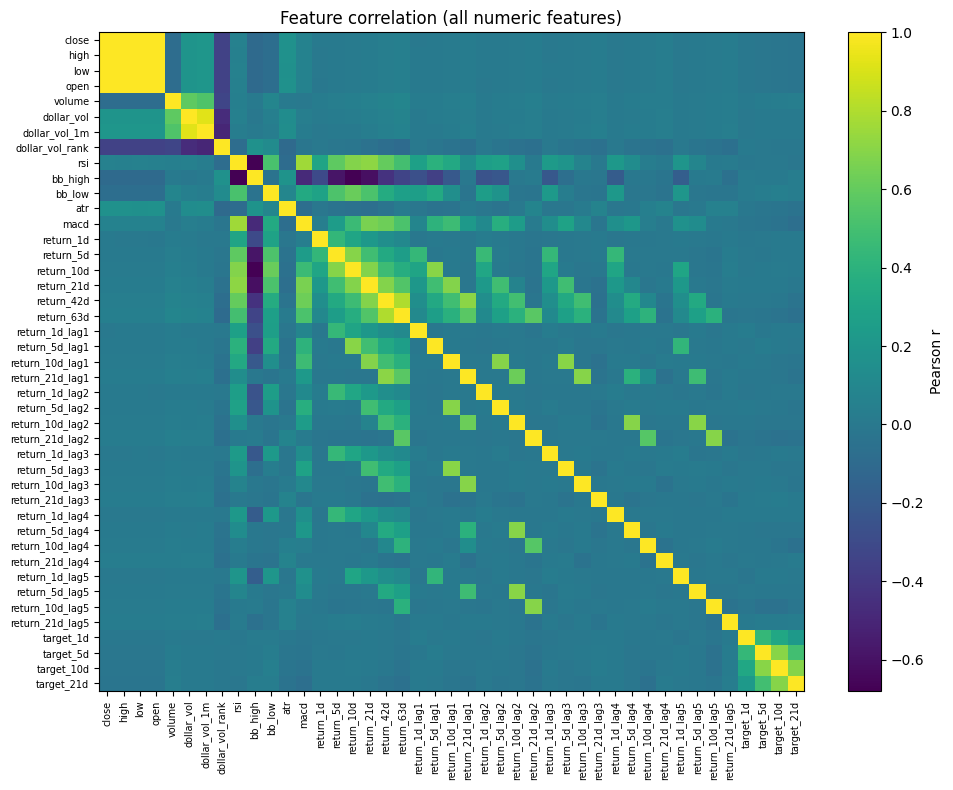

In [ ]:
numeric_cols = model_data.select_dtypes(include=[np.number])

corr_mat = numeric_cols.corr()

plt.figure(figsize=(10,8))
im = plt.imshow(corr_mat, aspect='auto')
plt.colorbar(im, label='Pearson r')

plt.xticks(
    ticks=np.arange(len(corr_mat.columns)),
    labels=corr_mat.columns,
    rotation=90,
    fontsize=7
)
plt.yticks(
    ticks=np.arange(len(corr_mat.index)),
    labels=corr_mat.index,
    fontsize=7
)

plt.title("Feature correlation (all numeric features)")
plt.tight_layout()
plt.show()


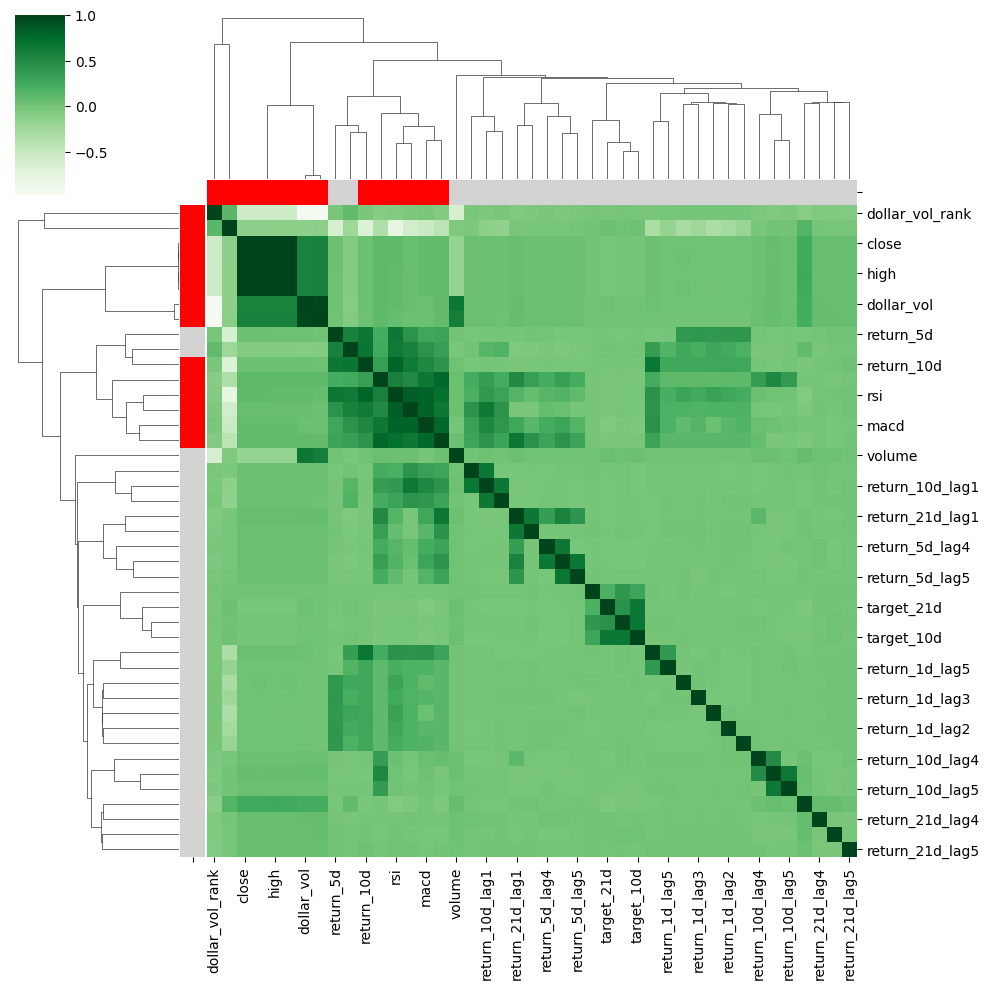

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

threshold = 0.7

abs_corr = corr.abs()
np.fill_diagonal(abs_corr.values, 0)  # ignore self-correlation (1.0)
strong_mask = (abs_corr >= threshold).any(axis=1)
strong_features = strong_mask.index[strong_mask].tolist()

row_color_map = pd.Series(
    ['red' if f in strong_features else 'lightgray' for f in corr.index],
    index=corr.index
)

sns.clustermap(
    corr,
    center=0,
    cmap='Greens',
    row_colors=row_color_map,
    col_colors=row_color_map
)
plt.show()


In [ ]:
# UNCOMMENT THIS BLOCK IF YOU NEED TO SAVE YOUR TABLE

# from google.colab import drive
# import os

# drive.mount('/content/drive')

# # RUN_DIR_STOCKS = f"/content/drive/MyDrive/Colab Notebooks/colab_runs/stocks_model_data_{time.strftime('%Y%m%d_%H%M%S')}"
# # h5_path = f"{RUN_DIR_STOCKS}/stocks"


# # # 2) Save paths/content/drive/MyDrive/Colab Notebooks
# # os.makedirs(RUN_DIR_STOCKS, exist_ok=True)


# # model_data.to_hdf(
# #     h5_path, key="stocks", mode="w", format="table",
# #     data_columns=True, complevel=9, complib="blosc"
# # )


# # # # list keys
# # with pd.HDFStore(h5_path, mode="r") as store:
# #     print(store.keys())

# # load full tables
# load_path = "/content/drive/MyDrive/Colab Notebooks/colab_runs/stocks_model_data_20251008_132715/stocks"
# stocks  = pd.read_hdf(load_path, key="stocks")

# model_data = stocks.copy()

Mounted at /content/drive


In [ ]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                  n_splits=3,
                  train_period_length=126,
                  test_period_length=21,
                  lookahead=None,
                  shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
      unique_dates = X.index.get_level_values('date').unique()
      days = sorted(unique_dates, reverse=True)
      n_days = len(days)

      split_idx = []
      for i in range(self.n_splits):

        test_end_idx = i*self.test_length
        test_start_idx = test_end_idx + self.test_length

        train_end_idx = test_start_idx + self.lookahead

        train_start_idx = train_end_idx + self.train_length

        if train_start_idx >= n_days:
            break

        split_idx.append([train_start_idx, train_end_idx,
                          test_start_idx, test_end_idx])

      dates = X.reset_index()[['date']]

      for train_start, train_end, test_start, test_end in split_idx:
        train_idx = dates[(dates.date > days[train_start])
                  & (dates.date <= days[train_end])].index

        test_idx = dates[(dates.date > days[test_start])
                  & (dates.date <= days[test_end])].index

        if self.shuffle:
          np.random.shuffle(list(train_idx))
        yield train_idx, test_idx


      def get_n_splits(self, X, y, groups=None):
        return self.n_splits

## Custom Models

In [ ]:
#RIDGE
class CustomRidge:
    def __init__(self, alpha=1.0, fit_intercept=True, random_state=None):
        self.alpha = float(alpha)
        self.fit_intercept = bool(fit_intercept)
        self.random_state = random_state

    def get_params(self, deep=True):
        return {
            "alpha": self.alpha,
            "fit_intercept": self.fit_intercept,
            "random_state": self.random_state,
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def _prepare_X(self, X):
        X = np.asarray(X, dtype=float)
        if self.fit_intercept:
            ones = np.ones((X.shape[0], 1), dtype=X.dtype)
            Xb = np.hstack([ones, X])
        else:
            Xb = X
        return Xb

    def fit(self, X, y):
        Xb = self._prepare_X(X)

        y = np.asarray(y, dtype=float)
        y = y.reshape(-1, 1) if y.ndim == 1 else y

        n_features_aug = Xb.shape[1]
        P = self.alpha * np.eye(n_features_aug, dtype=Xb.dtype)
        if self.fit_intercept:
            P[0, 0] = 0.0

        A = Xb.T @ Xb + P
        B = Xb.T @ y

        beta = np.linalg.solve(A, B)

        if self.fit_intercept:
            self.intercept_ = beta[0].ravel()
            body = beta[1:, :]
        else:
            self.intercept_ = np.zeros(y.shape[1])
            body = beta

        self.coef_ = body.ravel() if body.shape[1] == 1 else body.T
        if self.intercept_.size == 1:
            self.intercept_ = float(self.intercept_[0])

        self.n_features_in_ = np.asarray(X).shape[1]
        return self

    def predict(self, X):
        Xb = self._prepare_X(X)

        if self.fit_intercept:
            if self.coef_.ndim == 1:
                beta = np.concatenate([[self.intercept_], self.coef_])[:, None]
            else:
                beta = np.vstack([np.atleast_2d(self.intercept_).T, self.coef_.T])
        else:
            beta = self.coef_[:, None] if self.coef_.ndim == 1 else self.coef_.T

        y_pred = Xb @ beta

        return y_pred.ravel() if y_pred.shape[1] == 1 else y_pred

In [ ]:
#LASSO
class CustomLasso:
    def __init__(self, alpha=1.0, fit_intercept=True, random_state=None):
        self.alpha = float(alpha)
        self.fit_intercept = bool(fit_intercept)
        self.random_state = random_state

    def get_params(self, deep=True):
        return {
            "alpha": self.alpha,
            "fit_intercept": self.fit_intercept,
            "random_state": self.random_state,
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def _prepare_X(self, X):
        X = np.asarray(X, dtype=float)
        if self.fit_intercept:
            ones = np.ones((X.shape[0], 1), dtype=X.dtype)
            Xb = np.hstack([ones, X])
        else:
            Xb = X
        return Xb

    def fit(self, X, y):
        Xb = self._prepare_X(X)

        y = np.asarray(y, dtype=float)
        y = y.reshape(-1, 1) if y.ndim == 1 else y

        n_features_aug = Xb.shape[1]
        n_samples = Xb.shape[0]
        beta = np.zeros((n_features_aug, y.shape[1]))
        max_iter = 1000
        tol = 1e-4
        X_col_sq = (Xb ** 2).sum(axis=0)
        lam = n_samples * self.alpha


        for iteration in range(max_iter):
            beta_old = beta.copy()
            for j in range(n_features_aug):
              denom = X_col_sq[j]
              if denom == 0.0:
                  continue

              r = y - Xb @ beta
              rho = Xb[:, j:j+1].T @ r + denom * beta[j:j+1, :]

              if self.fit_intercept and j == 0:
                  beta[j:j+1, :] = rho / denom
              else:
                  beta[j:j+1, :] = np.sign(rho) * np.maximum(0.0, np.abs(rho) - lam) / denom

            if np.max(np.abs(beta - beta_old)) < tol:
                break
        if self.fit_intercept:
            self.intercept_ = beta[0].ravel()
            body = beta[1:, :]
        else:
            self.intercept_ = np.zeros(y.shape[1])
            body = beta

        self.coef_ = body.ravel() if body.shape[1] == 1 else body.T
        if self.intercept_.size == 1:
            self.intercept_ = float(self.intercept_[0])

        self.n_features_in_ = np.asarray(X).shape[1]
        return self

    def predict(self, X):
        Xb = self._prepare_X(X)

        if self.fit_intercept:
            if self.coef_.ndim == 1:
                beta = np.concatenate([[self.intercept_], self.coef_])[:, None]
            else:
                beta = np.vstack([np.atleast_2d(self.intercept_).T, self.coef_.T])
        else:
            beta = self.coef_[:, None] if self.coef_.ndim == 1 else self.coef_.T

        y_pred = Xb @ beta

        return y_pred.ravel() if y_pred.shape[1] == 1 else y_pred

## Linear Pipeline

In [ ]:
#RUN SIMPLE OLS PIPELINE
%%time


YEAR = 252
train_period_length = 63
test_period_length = 10
lookahead = 1

data = model_data[model_data.dollar_vol_rank<100]
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)


n_splits = int(3 * YEAR / test_period_length)
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
coef_records = []

for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test   = X.iloc[test_idx], y[target].iloc[test_idx]

    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    # store coefs
    coef_records.append(
        pd.Series(lr.coef_, index=X.columns, name=f'split_{i}')
    )

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,x.actuals)[0] * 100).to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,y_true=x.actuals))).to_frame('rmse')],
                       axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

coef_df = pd.concat(coef_records, axis=1).T

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

CPU times: user 11.6 s, sys: 22.7 ms, total: 11.6 s
Wall time: 7.39 s


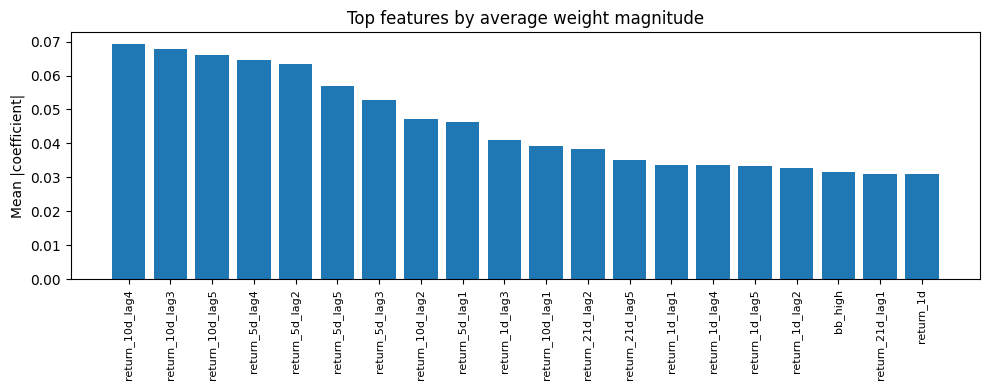

In [ ]:
mean_abs_coef = coef_df.abs().mean().sort_values(ascending=False)
import matplotlib.pyplot as plt
import numpy as np

top_n = 20  # show the 20 strongest features
top_feats = mean_abs_coef.head(top_n)

plt.figure(figsize=(10,4))
plt.bar(top_feats.index, top_feats.values)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Mean |coefficient|")
plt.title("Top features by average weight magnitude")
plt.tight_layout()
plt.show()


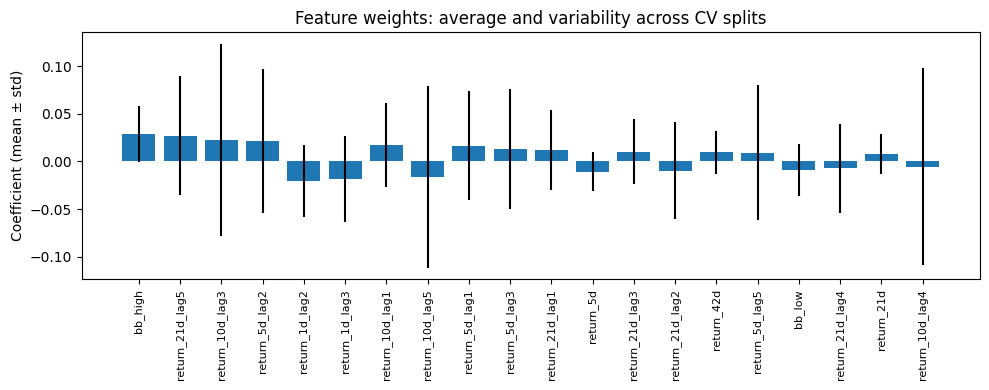

In [ ]:
coef_mean = coef_df.mean()
coef_std  = coef_df.std()

# pick strongest features by absolute mean weight
top_feats2 = coef_mean.abs().sort_values(ascending=False).head(top_n).index

plt.figure(figsize=(10,4))
plt.bar(top_feats2, coef_mean[top_feats2], yerr=coef_std[top_feats2])
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Coefficient (mean ± std)")
plt.title("Feature weights: average and variability across CV splits")
plt.tight_layout()
plt.show()


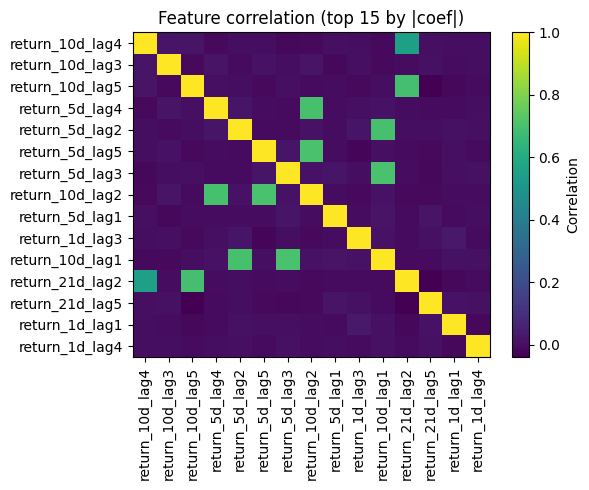

In [ ]:
top_feats = mean_abs_coef.index[:15]
corr_mat = X[top_feats].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr_mat, aspect='auto')
plt.xticks(range(len(top_feats)), top_feats, rotation=90)
plt.yticks(range(len(top_feats)), top_feats)
plt.colorbar(label="Correlation")
plt.title("Feature correlation (top 15 by |coef|)")
plt.tight_layout()
plt.show()


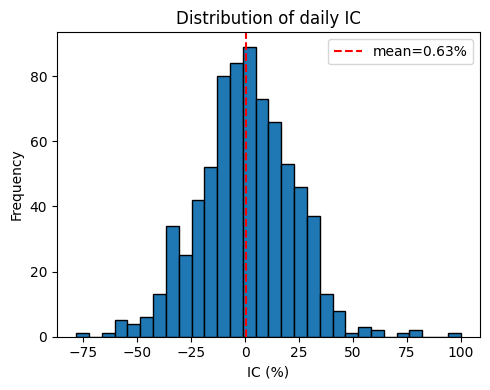

In [ ]:
plt.figure(figsize=(5,4))
plt.hist(ic_daily.values, bins=30, edgecolor='black')
plt.axvline(ic_daily.mean(), color='red', linestyle='--', label=f"mean={ic_daily.mean():.2f}%")
plt.title("Distribution of daily IC")
plt.xlabel("IC (%)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#RUN MAIN PIPELINE FOR RIDGE & LASSO

%%time


ridge_alphas = np.logspace(-4, 4, 9)
# lasso_alphas = np.logspace(-5, 1, 15)
lasso_alphas = np.logspace(-4, 1, 20)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))
lasso_alphas = sorted(list(lasso_alphas) + list(lasso_alphas * 5))


data = model_data[model_data.dollar_vol_rank<100]
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)


YEAR = 252
train_period_length = 63
test_period_length = 10
lookahead = 1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)


target = f'target_{lookahead}d'
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

ridge_coeffs, ridge_scores_list, ridge_predictions_list = {}, [], []

custom_ridge_model = CustomRidge(fit_intercept=False,
                                 random_state=42)

sklearn_lasso_model = Lasso(
                  fit_intercept=False,
                  random_state=42,
                  tol=1e-2,
                  max_iter=10000,
                  warm_start=True,
                  selection='random')

custom_lasso_model = CustomLasso(fit_intercept=False,
                                 random_state=42,
                                 tol=1e-3,
                                 max_iter=10000,
                                 warm_start=True,
                                 selection='random')

def daily_ic(df):
    # df has columns: predicted, actuals for a single date
    if df['predicted'].nunique() < 2 or df['actuals'].nunique() < 2:
        return np.nan
    return spearmanr(df['predicted'], df['actuals'])[0] * 100

for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    start = time.time()
    #simply replace "custom_lasso_model" to custom_ridge_model or sklearn_lasso_model
    model = clone(custom_lasso_model).set_params(alpha=alpha)

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    pipe = Pipeline([
        ('scaler', x_scaler),
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        x_scaler.fit(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        pipe.fit(X=X_train, y=y_train_scaled)

        y_pred_scaled = pipe.predict(X_test)
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(daily_ic).to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores_list.append(scores.assign(alpha=alpha))
        ridge_predictions_list.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')


# 1) Build final tables
ridge_predictions = pd.concat(ridge_predictions_list)
ridge_scores      = pd.concat(ridge_scores_list)
ridge_coeffs_df = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs_df.index.name = 'alpha'
ridge_coeffs_df = ridge_coeffs_df.reset_index()


0.0001 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+03, tolerance: 6.057e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+03, tolerance: 5.966e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.559e+02, tolerance: 6.056e

0.00018329807108324357 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.190e+02, tolerance: 6.144e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.756e+02, tolerance: 5.966e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e+02, tolerance: 5.964e

0.0003359818286283781 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.235e+02, tolerance: 5.967e+01
  model = cd_fast.enet_coordinate_descent(


0.0005 0.0006158482110660267 0.0009164903554162179 0.0011288378916846883 0.0016799091431418905 0.00206913808111479 0.0030792410553301336 0.00379269019073225 0.0056441894584234415 0.0069519279617756054 0.01034569040557395 0.012742749857031334 0.01896345095366125 0.023357214690901212 0.03475963980887803 0.04281332398719392 0.06371374928515668 0.07847599703514607 0.11678607345450606 0.14384498882876628 0.2140666199359696 0.26366508987303583 0.39237998517573036 0.4832930238571752 0.7192249441438314 0.8858667904100823 1.318325449365179 1.623776739188721 2.416465119285876 2.9763514416313193 4.429333952050412 5.455594781168514 8.118883695943605 10.0 14.881757208156596 27.277973905842572 50.0 

CPU times: user 11min 4s, sys: 6.7 s, total: 11min 11s
Wall time: 11min 21s


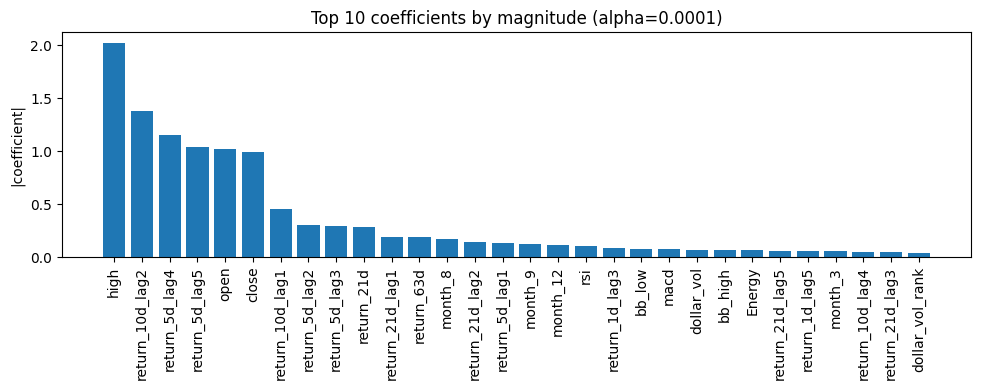

In [ ]:
alpha_to_plot = ridge_scores.groupby('alpha')['ic'].mean().idxmax()

row = (
    ridge_coeffs_df
    .set_index('alpha')
    .loc[alpha_to_plot]
)

# pick top 10 by absolute value
top10_idx = row.abs().nlargest(30).index
top10_abs = row.abs()[top10_idx].reindex(top10_idx)

plt.figure(figsize=(10,4))
plt.bar(top10_abs.index, top10_abs.values)
plt.xticks(rotation=90)
plt.ylabel("|coefficient|")
plt.title(f"Top 10 coefficients by magnitude (alpha={alpha_to_plot})")
plt.tight_layout()
plt.show()


In [ ]:
# pick best alpha by IC
best_alpha = ridge_scores.groupby('alpha')['ic'].mean().idxmax()

# daily IC for that alpha
ic_best = ridge_scores[ridge_scores['alpha'] == best_alpha]['ic']

# overall IC (mean)
overall_ic_pct = ic_best.mean()
overall_ic_raw = overall_ic_pct / 100
print(f"Overall IC (alpha={best_alpha}): {overall_ic_pct:.2f}%  (raw: {overall_ic_raw:.4f})")



Overall IC (alpha=0.00379269019073225): 1.03%  (raw: 0.0103)


In [ ]:
# --- plotting helpers ---

def plot_ic_distribution(df, ax=None):
    d = df.copy()
    d = d.loc[d['ic'].notna()]
    if ax is not None:
        ax = sns.histplot(d['ic'], ax=ax, kde=True)
    else:
        ax = sns.histplot(d['ic'], kde=True)
    mean, median = d['ic'].mean(), d['ic'].median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            ha='left', va='center', transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

def plot_rolling_ic(df):
    d = df.sort_index()
    rolling_result = d.rolling(21).mean().dropna()

    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))

    mean_ic = d['ic'].mean()
    rolling_result['ic'].plot(ax=axes[0],
                              title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                              lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = d['rmse'].mean()
    rolling_result['rmse'].plot(ax=axes[1],
                                title=f'Root Mean Squared Error (Mean: {mean_rmse:.4f})',
                                lw=1,
                                ylim=(0, d['rmse'].max()))
    axes[1].axhline(mean_rmse, lw=1, ls='--', color='k')

    sns.despine()
    plt.tight_layout()
    return fig, axes


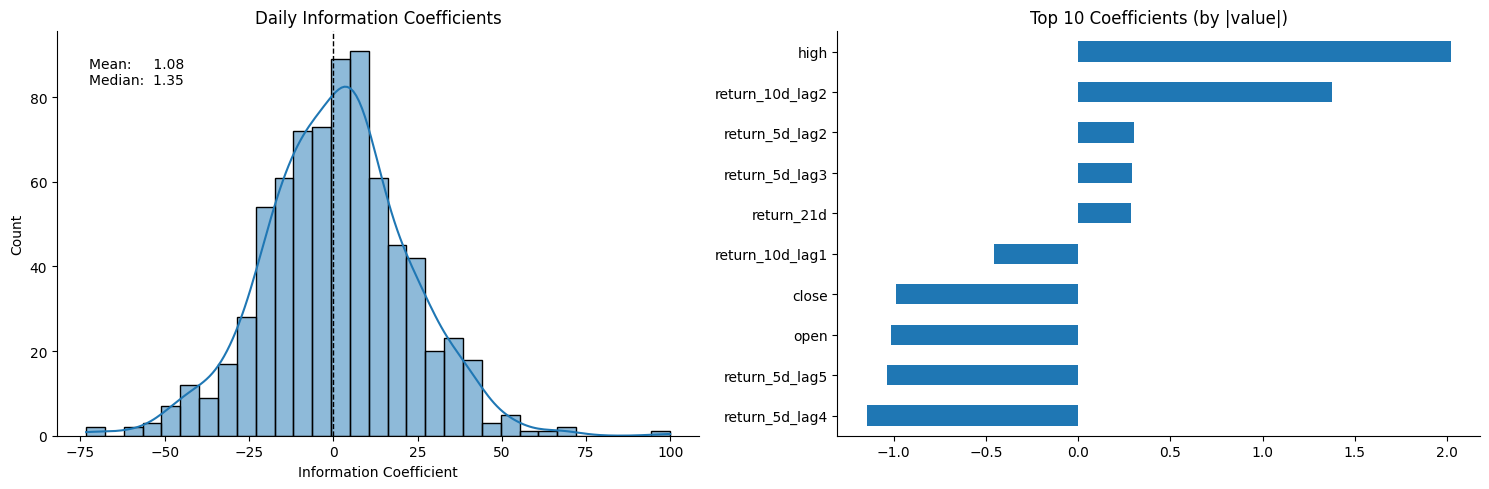

In [ ]:
best_alpha = ridge_scores.groupby('alpha')['ic'].mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores['alpha'] == best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

row = (ridge_coeffs_df[ridge_coeffs_df['alpha'] == best_alpha]
       .drop(columns=['alpha'])
       .iloc[0])

top10_idx = row.abs().nlargest(10).index
(row[top10_idx]
 .sort_values()
 .plot.barh(ax=axes[1], title='Top 10 Coefficients (by |value|)'))
sns.despine()
fig.tight_layout()
